# Online Shoppers Intention.

#### Import packages

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE


#hide warnings
import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
# read data
customer_data = pd.read_csv('shoppers_intention.csv')

### Look at the data

In [3]:
print(customer_data.head())
print(customer_data.info())
print(customer_data.describe())

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

The dataframe has 12330 rows and 18 columns

There are 17 features in this dataframe.

The target variable in this dataframe is `Revenue`

## Visual EDA

#### visual eda numerical columns

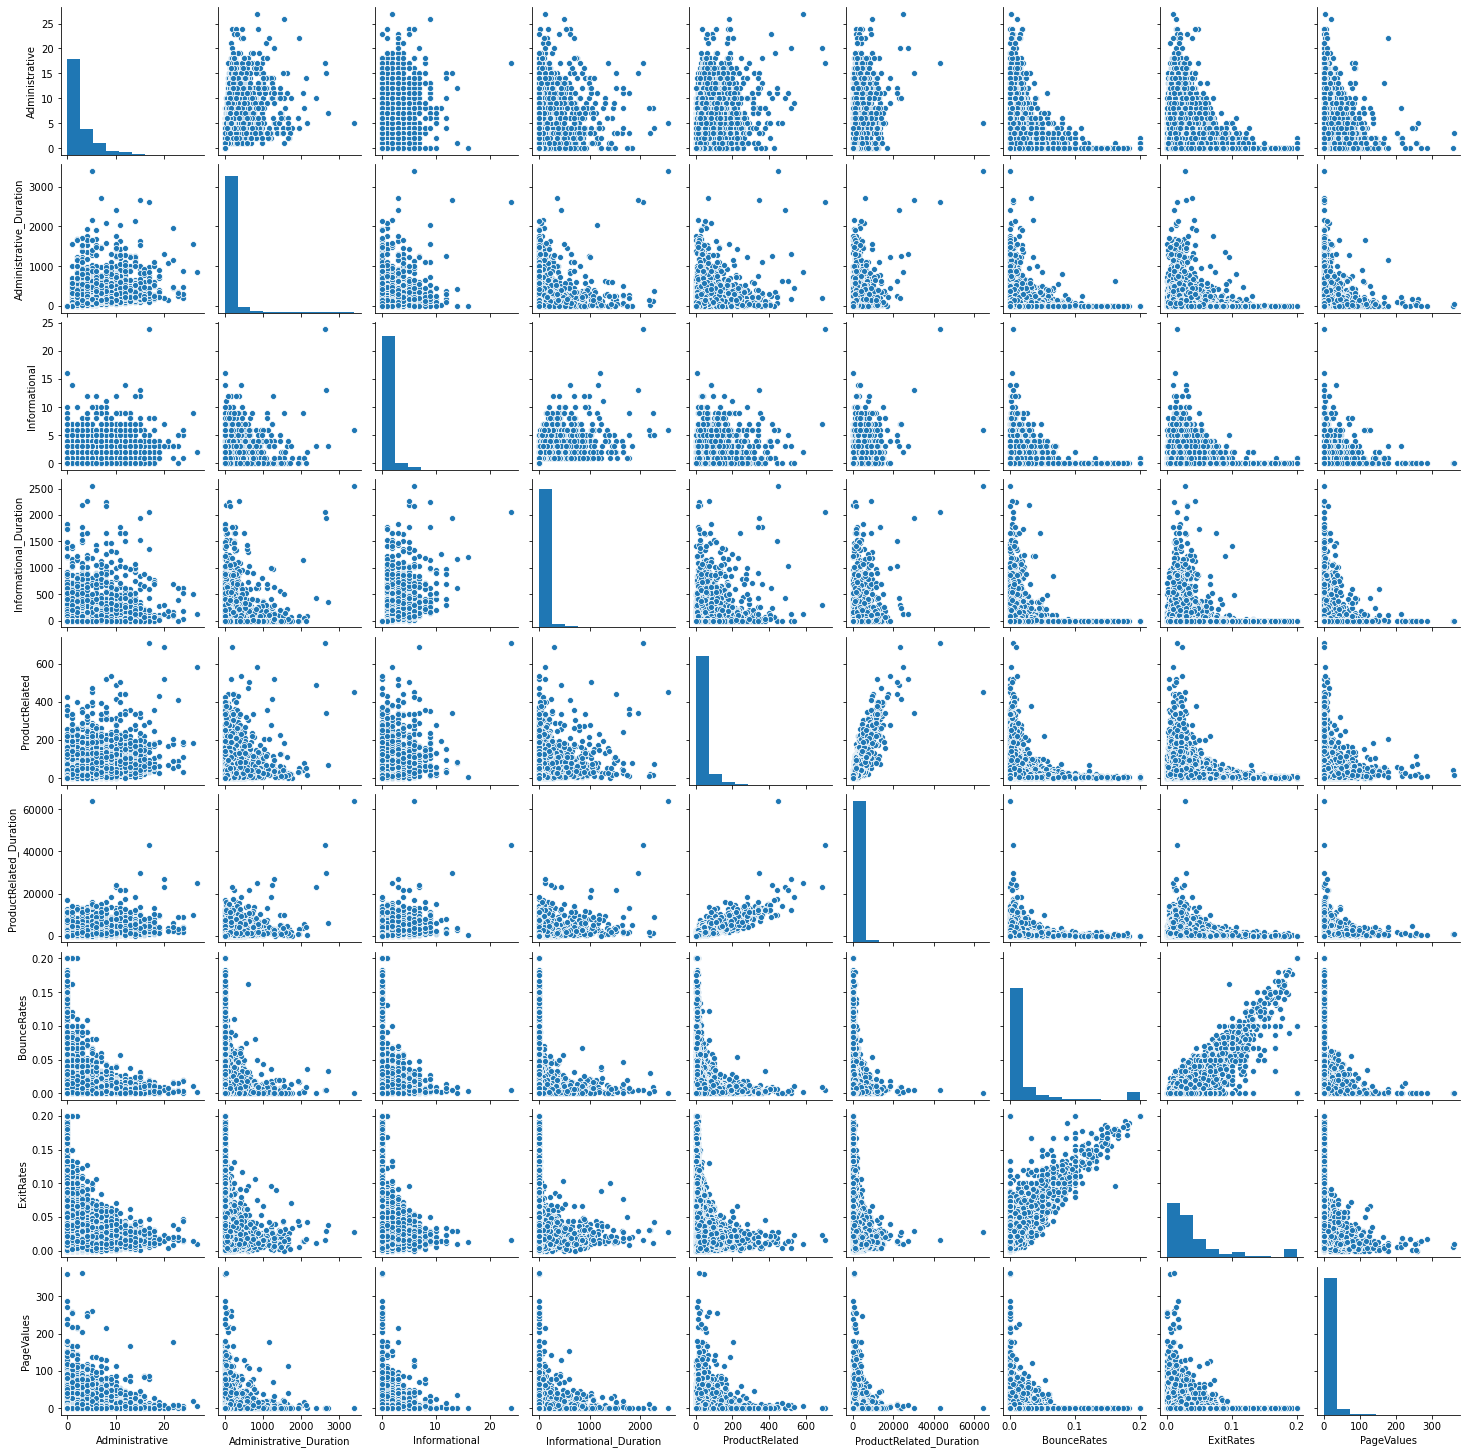

In [4]:
#pairplot for all numerical columns
p=sns.pairplot(customer_data[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues']],  diag_kind="hist")
p.fig.set_size_inches(20,20)

no numerical columns seem to have any incorrect values, i.e. negative numbers

##### visual EDA categorical

Using the seaborn package I will visualise the categorical columns

In [5]:
#theme
sns.set(style='whitegrid')

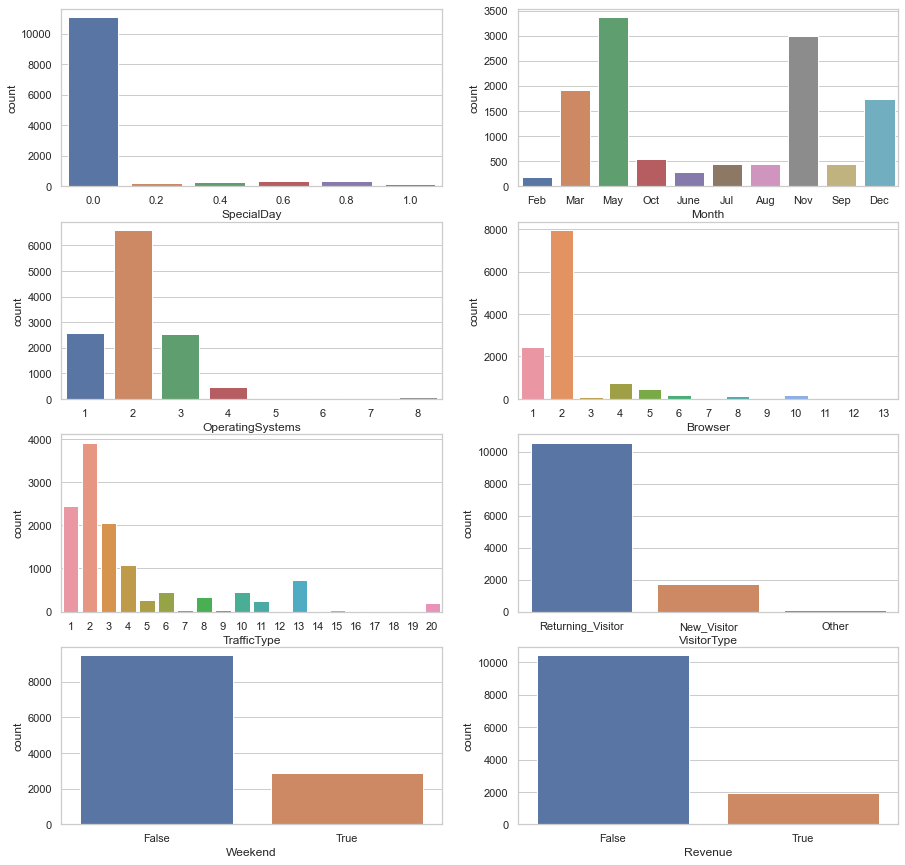

In [6]:
fig, [[ax1, ax2],[ax3, ax4],[ax5,ax6],[ax7,ax8]] = plt.subplots(4,2,figsize=(15,15))
sns.countplot(x='SpecialDay', data=customer_data,ax=ax1)
sns.countplot(x='Month', data=customer_data,ax=ax2)
sns.countplot(x='OperatingSystems', data=customer_data, ax=ax3)
sns.countplot(x='Browser', data=customer_data, ax=ax4)
sns.countplot(x='TrafficType', data=customer_data,ax=ax5)
sns.countplot(x='VisitorType', data=customer_data,ax=ax6)
sns.countplot(x='Weekend', data=customer_data,ax=ax7)
sns.countplot(x='Revenue', data=customer_data,ax=ax8)
plt.show()

##### class imbalance

In [7]:
#check if the target column is imbalanced
print(customer_data.groupby('Revenue')['Revenue'].count())

Revenue
False    10422
True      1908
Name: Revenue, dtype: int64


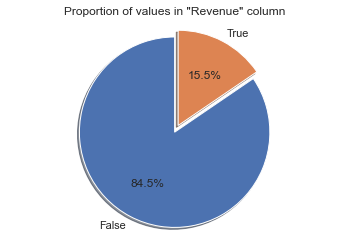

In [8]:
#visualise imbalance with pie chart 

Rev =(customer_data.groupby('Revenue')['Revenue'].count())

#get percentage
sizes = [Rev[0],Rev[1]]
#label
label = ['False','True']


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90,explode=(0.08,0.0))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of values in "Revenue" column')
plt.show()

#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

## Data preprocessing 

#### missing values?

In [9]:
print(customer_data.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


there are no NA values in the dataframe

No missing values are represented by strings

### Encoding categorical data

need to encode the numerical data to categorical data  and use pd.dummies on `OperatingSystems`,`Browser`,`TrafficType`,`Weekend`,`Region`,`SpecialDay`, `Month` and `VisitorType`

In [10]:
# change type of the catgorical columns to catagorical data 
for i in customer_data.columns[9:17]:
    customer_data[i] = pd.Categorical(customer_data[i])      

In [11]:
customer_data = pd.get_dummies(customer_data,columns=['SpecialDay', 'Month', 'OperatingSystems','Browser','Region',
                                'TrafficType','VisitorType','Weekend'])

### test, validation and train split

In [12]:
# create arrays for the features and the target variable 
y = customer_data['Revenue']

# selected features 
X = customer_data.drop('Revenue',axis=1)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=24, stratify = y)

# split the train data now into train validation and cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=24)

Print the shape of the data

In [13]:
print('Shape of X train data:', X_train.shape)
print('Shape of X test data:', X_test.shape)
print('Shape of X cross validation data:', X_cv.shape)
print('Shape of y train data:', y_train.shape)
print('Shape of y test data:', y_test.shape)
print('Shape of y cross validation data:', y_cv.shape)

Shape of X train data: (7891, 80)
Shape of X test data: (2466, 80)
Shape of X cross validation data: (1973, 80)
Shape of y train data: (7891,)
Shape of y test data: (2466,)
Shape of y cross validation data: (1973,)


### feature scaling

Looking at the histograms no features look Gaussian however due to the central limit theorem, the data will be approximately normal as there are a lot of observations.

So I will standardize the features.

https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [14]:
columns = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues']

standard_scale = StandardScaler()   

# to default 0 mean and 1 standard deviation
for i in columns:
    X_train[i] = standard_scale.fit_transform(X_train[[i]])
    X_test[i] = standard_scale.fit_transform(X_test[[i]])
    X_cv[i] = standard_scale.fit_transform(X_cv[[i]])

### Feature selection

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top features for the dataset.


https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

[5.14877270e-02 4.90363045e-02 3.06821390e-02 2.81686626e-02
 6.34783658e-02 6.32789339e-02 4.66195578e-02 7.00490770e-02
 2.34865754e-01 4.37337060e-03 8.96719972e-04 1.20502293e-03
 1.46682029e-03 1.08726744e-03 7.13699244e-04 5.44496240e-03
 8.10934661e-03 7.89061562e-04 5.46310232e-03 3.42986801e-03
 7.57720331e-03 8.67816687e-03 1.98895589e-02 6.13089619e-03
 6.31716357e-03 9.08824890e-03 1.21362922e-02 9.25699946e-03
 5.46203895e-03 1.77583797e-04 5.73329276e-04 3.92509883e-04
 8.06313436e-04 8.58093204e-03 1.32402663e-02 9.29210461e-04
 8.15422691e-03 5.98485270e-03 1.89397469e-03 1.37558937e-03
 1.57484817e-03 4.16953449e-06 2.64203168e-03 1.82733822e-04
 6.11191614e-04 5.57006132e-04 1.68940185e-02 1.08489791e-02
 1.42837508e-02 1.09763367e-02 5.08594924e-03 8.59048648e-03
 7.73085480e-03 5.38137356e-03 6.70082458e-03 8.80412207e-03
 1.28960402e-02 8.09045501e-03 7.04679337e-03 3.93526802e-03
 3.69113865e-03 1.84128493e-03 4.44482095e-03 2.97864141e-04
 4.97998986e-03 4.323914

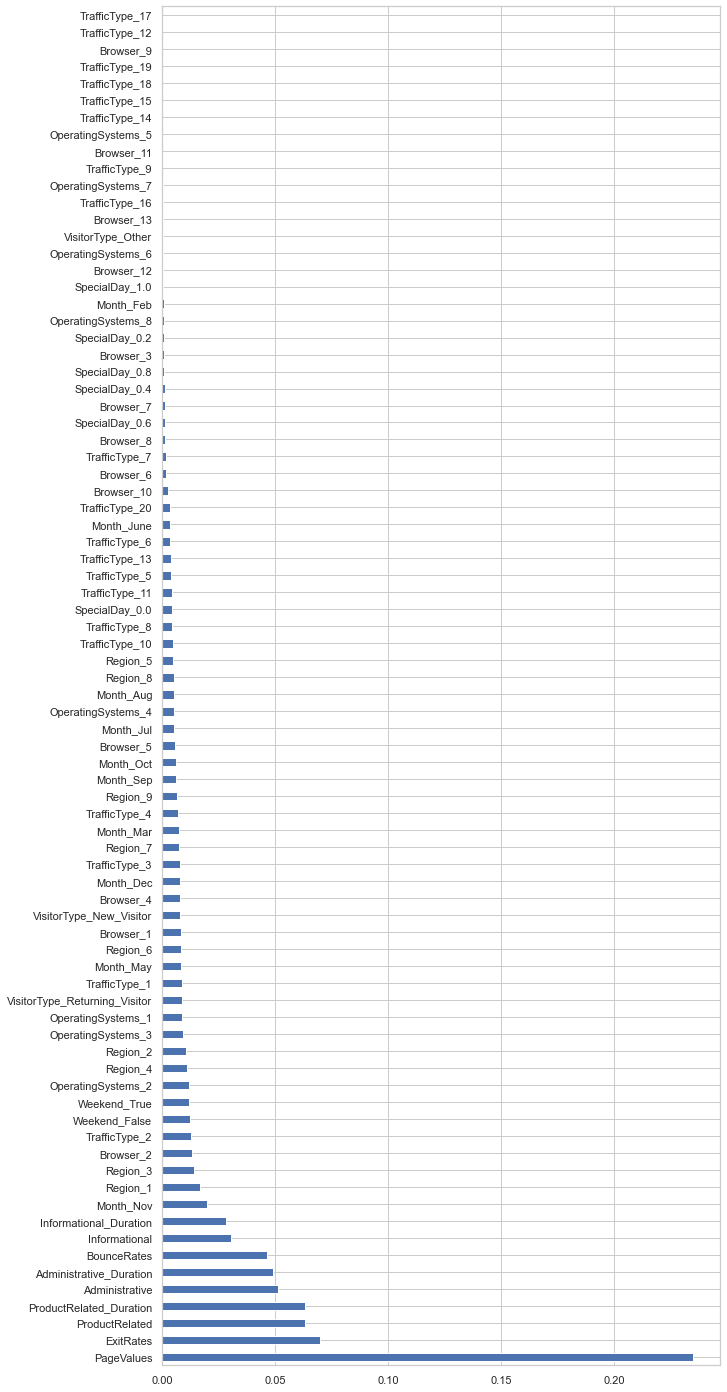

In [15]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)
print(extra_trees.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(extra_trees.feature_importances_, index=X_train.columns)
feat_importances.nlargest(82).plot(kind='barh',figsize=(10, 25))
plt.show()

drop features that have 0 feature importance 

In [16]:
X_train = X_train.drop(['Browser_12','Month_Feb','OperatingSystems_6','Browser_13','TrafficType_19','TrafficType_18',
             'Browser_12','TrafficType_16','TrafficType_14','OperatingSystems_5',
             'Browser_11','Browser_9','TrafficType_12','TrafficType_17'], 
            axis = 1)
X_test = X_test.drop(['Browser_12','Month_Feb','OperatingSystems_6','Browser_13','TrafficType_19','TrafficType_18',
             'Browser_12','TrafficType_16','TrafficType_14','OperatingSystems_5',
             'Browser_11','Browser_9','TrafficType_12','TrafficType_17'], 
            axis = 1)
X_cv = X_cv.drop(['Browser_12','Month_Feb','OperatingSystems_6','Browser_13','TrafficType_19','TrafficType_18',
             'Browser_12','TrafficType_16','TrafficType_14','OperatingSystems_5',
             'Browser_11','Browser_9','TrafficType_12','TrafficType_17'], 
            axis = 1)

# Model implementation


### K nearest neighbours

https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

In [17]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

#hyperparameters to test
n_neighbors = range(1, 31)
weights = ['uniform','distance']

param_grid = {'weights': weights,
             'n_neighbors': n_neighbors} 

#randomized search
knn_rcv = RandomizedSearchCV(knn, param_grid, cv=10, scoring='f1', n_iter=10, random_state=24)
    
# Fit the classifier to the training data
knn_rcv.fit(X_train, y_train)

# Predict the labels of the cv data: y_pred
y_pred = knn_rcv.predict(X_cv)

# Print the best values
print(knn_rcv.best_score_)
print(knn_rcv.best_params_)
print(knn_rcv.best_estimator_)
print(knn_rcv.score(X_cv, y_cv))
print(classification_report(y_cv, y_pred))

0.4799810050879483
{'weights': 'distance', 'n_neighbors': 3}
KNeighborsClassifier(n_neighbors=3, weights='distance')
0.46511627906976744
              precision    recall  f1-score   support

       False       0.90      0.95      0.92      1668
        True       0.57      0.39      0.47       305

    accuracy                           0.86      1973
   macro avg       0.73      0.67      0.69      1973
weighted avg       0.84      0.86      0.85      1973



In [18]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

knn.fit(X_train, y_train)

# Predict the labels of the cv data: y_pred
y_pred = knn.predict(X_test)

# Print the best values
print(knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.8714517437145174
              precision    recall  f1-score   support

       False       0.90      0.95      0.93      2084
        True       0.62      0.45      0.52       382

    accuracy                           0.87      2466
   macro avg       0.76      0.70      0.72      2466
weighted avg       0.86      0.87      0.86      2466



In [19]:
# df for the model results
df = pd.DataFrame([['KNN',f1_score(y_test, y_pred)]], columns=['Model','F1 Score'])

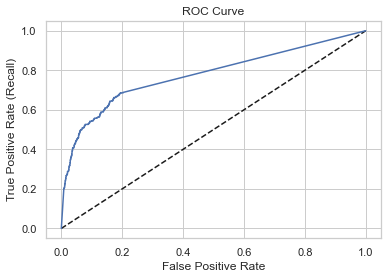

In [20]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.show()

### Logistic Regression Model

In [21]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space,
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'penalty' :['none', 'l1', 'l2', 'elasticnet']}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='f1')

# Fit it to the data
logreg_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'penalty': 'l1', 'solver': 'saga'}
Best score is 0.5069461246045931


In [22]:
# logistic regression with best parameters
logreg = LogisticRegression(C =0.4393970560760795, penalty='l1', solver='saga')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

# Print the best values
print(logreg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.8872668288726683
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      2084
        True       0.74      0.42      0.54       382

    accuracy                           0.89      2466
   macro avg       0.82      0.70      0.74      2466
weighted avg       0.88      0.89      0.87      2466



In [23]:
df = df.append({'Model':'Logistic Regression','F1 Score':f1_score(y_test, y_pred)},ignore_index=True)

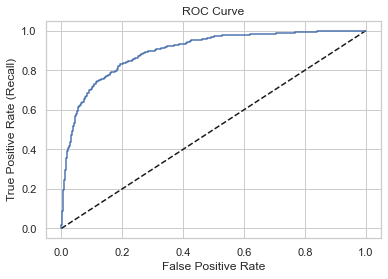

In [24]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.show()

### SVM

In [25]:
# Setup the hyperparameter grid
c_space = [0.1,1,10,100,1000]
gamma = [0.001, 0.01, 0.1, 1]
param_grid = {'C': c_space, 
              'gamma':gamma}
#Apply SVM 
svm = SVC()

# Instantiate the GridSearchCV object: svm_cv
svm_cv = GridSearchCV(svm, param_grid, cv=5,scoring='f1')

# Fit it to the data
svm_cv.fit(X_train,y_train)

print("Tuned SVM Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

Tuned SVM Parameters: {'C': 100, 'gamma': 0.01}
Best score is 0.6028436523012503


In [26]:
#Svm with best parameters

svm = SVC(C=10,gamma=0.01)

svm.fit(X_train,y_train)

y_pred = svm.predict(X_test)

print(svm.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.8961881589618816
              precision    recall  f1-score   support

       False       0.91      0.97      0.94      2084
        True       0.76      0.49      0.59       382

    accuracy                           0.90      2466
   macro avg       0.83      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



In [27]:
df = df.append({'Model':'SVM','F1 Score':f1_score(y_test, y_pred)},ignore_index=True)

 not able to plot roc curve for svm


## SMOTE

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [28]:
# Instantiate smote
oversample = SMOTE(sampling_strategy='minority',random_state=12)

# fit to training set
X_train, y_train = oversample.fit_resample(X_train, y_train)

### KNN with SMOTE

In [29]:
# Create a k-NN classifier
knn_s = KNeighborsClassifier()

#hyperparameters to test
n_neighbors = range(1, 31)
weights = ['uniform','distance']

param_grid = {'weights': weights,
             'n_neighbors': n_neighbors} 

#randomized search
knn_rcv_s = RandomizedSearchCV(knn_s, param_grid, cv=10, scoring='f1', n_iter=10, random_state=24)
    
# Fit the classifier to the training data
knn_rcv_s.fit(X_train, y_train)

# Print the best values
print(knn_rcv_s.best_score_)
print(knn_rcv_s.best_params_)
print(knn_rcv_s.best_estimator_)

0.9220646215302158
{'weights': 'uniform', 'n_neighbors': 2}
KNeighborsClassifier(n_neighbors=2)


In [30]:
knn_s= KNeighborsClassifier(n_neighbors=2, weights='uniform')

knn_s.fit(X_train, y_train)

# Predict the labels of the cv data: y_pred
y_pred = knn_s.predict(X_test)

print(knn_s.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.8309002433090025
              precision    recall  f1-score   support

       False       0.92      0.88      0.90      2084
        True       0.46      0.58      0.52       382

    accuracy                           0.83      2466
   macro avg       0.69      0.73      0.71      2466
weighted avg       0.85      0.83      0.84      2466



In [31]:
df = df.append({'Model':'KNN (SMOTE)','F1 Score':f1_score(y_test, y_pred)},ignore_index=True)

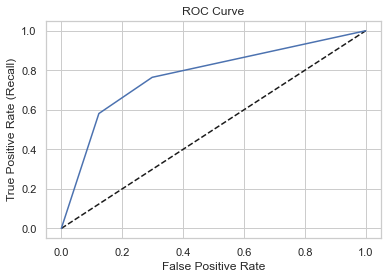

In [32]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn_s.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.show()

### Logistic Regression with SMOTE

In [33]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 30)
param_grid = {'C': c_space,
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'penalty' :['none', 'l1', 'l2', 'elasticnet']}

# Instantiate a logistic regression classifier: logreg
logreg_s = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv_s = GridSearchCV(logreg, param_grid, cv=5,scoring='f1')

# Fit it to the data
logreg_cv_s.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv_s.best_params_)) 
print("Best score is {}".format(logreg_cv_s.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.1082636733874054, 'penalty': 'l2', 'solver': 'saga'}
Best score is 0.8877609479875032


In [34]:
# logistic regression with best parameters
logreg_s = LogisticRegression(C = 0.1082636733874054, penalty= 'l2',solver= 'saga' )

logreg_s.fit(X_train,y_train)

y_pred = logreg_s.predict(X_test)

# Print the best values
print(logreg_s.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.889294403892944
              precision    recall  f1-score   support

       False       0.93      0.94      0.93      2084
        True       0.65      0.61      0.63       382

    accuracy                           0.89      2466
   macro avg       0.79      0.77      0.78      2466
weighted avg       0.89      0.89      0.89      2466



In [35]:
df = df.append({'Model':'Logistic Regression (SMOTE)','F1 Score':f1_score(y_test, y_pred)},ignore_index=True)

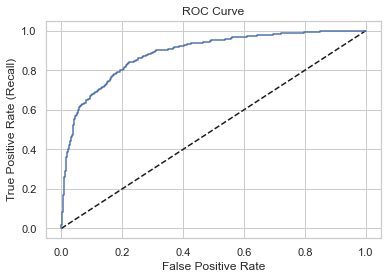

In [36]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg_s.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.show()

### SVM with SMOTE

In [37]:
# Setup the hyperparameter grid
c_space = [0.1,1,10,100,1000]
gamma = [0.001, 0.01, 0.1, 1]
param_grid = {'C': c_space, 
              'gamma':gamma}
#Apply SVM 
svm_s = SVC()

# Instantiate the GridSearchCV object: svm_cv
svm_cv_s = GridSearchCV(svm, param_grid, cv=5,scoring='f1')

# Fit it to the data
svm_cv_s.fit(X_train,y_train)

print("Tuned SVM Parameters: {}".format(svm_cv_s.best_params_)) 
print("Best score is {}".format(svm_cv_s.best_score_))

Tuned SVM Parameters: {'C': 10, 'gamma': 1}
Best score is 0.9136183130430778


In [38]:
#Svm with best parameters

svm_s = SVC(C=10,gamma=1)

svm_s.fit(X_train,y_train)

y_pred = svm_s.predict(X_test)

print(svm_s.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.8495539334955393
              precision    recall  f1-score   support

       False       0.87      0.97      0.92      2084
        True       0.54      0.18      0.27       382

    accuracy                           0.85      2466
   macro avg       0.70      0.58      0.59      2466
weighted avg       0.82      0.85      0.82      2466



In [39]:
df = df.append({'Model':'SVM (SMOTE)','F1 Score':f1_score(y_test, y_pred)},ignore_index=True)

## Model Results

In [40]:
print(df)

                         Model  F1 Score
0                          KNN  0.521870
1          Logistic Regression  0.535117
2                          SVM  0.592357
3                  KNN (SMOTE)  0.515679
4  Logistic Regression (SMOTE)  0.629579
5                  SVM (SMOTE)  0.268245


The best model is the Logistic regression with SMOTE